# Named Entity Recognition with Multi-task Neural Network 

Train a model with words from sentences, words' POS tags and entities to recognize named entities with a multi-task neural network

This network is trained with two tasks: named entity segmentation task and named entity classification task. To train the model, it takes orthographic, word and lexicon features of words with pre-trained embeddins. In addition to the neural network classifier, to employ the sequential information of sentences, a conditional random field classifier is applied to predict classes. 

Twitter word settings:
    
    window = 3 tokens

    embeddings -> twitter pre-trained embeddings, Godin

    dimensions = 400

    LSTM units = 100 -> 200 (Bi-LSTM)

Other settings:

    Epochs -> 5

    Batch size -> 500

    Opimizer -> Admax

    Seed 1337 for reproducibility
    
- Note that pre-trained embedding is too large to include in this project, please download the Twitter Word2vec model from http://fredericgodin.com/software/ and place under embeddings/twitter folder

This downloaded zip contains a word2vec model trained on Twitter data as described in:

Godin, F., Vandersmissen, B., De Neve, W., & Van de Walle, R. (2015).
Multimedia Lab @ ACL W-NUT NER shared task: Named entity recognition for Twitter microposts using distributed word representations.
Workshop on Noisy User-generated Text, ACL 2015.

and the code is modified by the authors of the paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
seed_number = 1337
np.random.seed(seed_number)

from common import utilities as utils
from common import representation as rep
from models import network
from models import crf
from settings import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import model_from_json

In [2]:
from Multi_Task_NER import Multi_Task_NER

# Loading Data, including words, POS Tags, Entity Tags, and Loading Embeddings

Give the path of data and read it into the project

In [3]:
train_file = "tests/ner_test_input/train.txt"
valid_file = "tests/ner_test_input/valid.txt"
test_file = "tests/ner_test_input/test.txt"

fileNames = {}
fileNames['train'] = train_file
fileNames['valid'] = valid_file
fileNames['test'] =test_file

multi_task = Multi_Task_NER()

data = multi_task.read_dataset(fileNames)


nunber of category: 10
['I-FAC', 'I-WORK_OF_ART', 'B-CARDINAL', 'I-PERSON', 'B-FAC', 'B-ORDINAL', 'B-PERSON', 'O', 'B-GPE', 'B-WORK_OF_ART']
Loading twitter embeddings...
Loading gazetteers embeddings...


# Encoding Words, Labels, POS Tags, Orthogaphy and Gazetteers

Geneating encodings with emneddings

In [4]:
embedding = multi_task.generating_encoding(data)

Generating encodings...


# Building and Training Neural Network

inputs from 

    Convoluational Neural Network: capture orthographic features

    Bidirectional LSTM: capture word features

    Dense Nerwork: capture lexicon features
    
Multi-task Neural Network

    segmentation task: identify whether a token is a named entity or not
    
    classification task: classify tokens in to named entity classes
   

In [5]:
hist = multi_task.train([data, embedding])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
10
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_ortho_input (InputLayer)   (None, 20)           0                                            
__________________________________________________________________________________________________
char_ortho_embed (Embedding)    (None, 20, 30)       150         char_ortho_input[0][0]           
__________________________________________________________________________________________________
word_twitter_input (InputLayer) (None, 3)            0                                            
__________________________________________________________________________________________________
word_postag_input 

Epoch 5/5
72/72 [==============================] - 0s 503us/sample - loss: 2.6238 - bin_output_loss: 0.5640 - cat_output_loss: 2.0598 - bin_output_fbeta_score: nan - bin_output_acc: 0.8472 - cat_output_fbeta_score: nan - cat_output_acc: 0.4167 - val_loss: 2.6238 - val_bin_output_loss: 0.5969 - val_cat_output_loss: 2.0269 - val_bin_output_fbeta_score: nan - val_bin_output_acc: 0.7778 - val_cat_output_fbeta_score: nan - val_cat_output_acc: 0.7222


# Saving Model

The model and weights will be saved in the same directory as data

In [6]:
multi_task.save_model('tests/ner_test_input/')

# Predicting Entity Tags with Test Data

Predictios come from:
    
    Neural Network Classifier
    
    Conditional Random Field Classifier:
            
            Use the weights of common densen neural network as inputs

Since CRF classifier always has better performance than NN classifier, this project will store the predictions generated by CRF clasifier.

In [7]:
decoded_predictions = multi_task.predict([data, embedding])
ground_truth = multi_task.convert_ground_truth(data)[0]
NN_pre = decoded_predictions[0]
#ground_truth = ground_truth
test_words = data[2][0]
CRF_pre = decoded_predictions[1]

file_path = 'tests/ner_test_input/output.txt'
file = open(file_path, 'w')
for i in range(len(test_words)):
    file.write(str(test_words[i])+" "+str(ground_truth[i])+" "+ str(CRF_pre[i])+'\n')

file.close()
print("output format: ")
file_path = 'tests/ner_test_input/output.txt'
file = open(file_path, 'r')
print()
for line in file.readlines()[:5]:
    print(line[:-1])

50/50 [==============================] - 0s 7ms/sample
output format: 

The O O
Dixie O O
Chicks O O
are O O
the O O


# Evaluating Predictions

Compare the predictions of NN classifier and CRF classifier

Evaluation metrics:
    
    Precision
    
    Recall
    
    F1-Score
    
The confusion matrix and results of evaluation will be printed
  

In [8]:
target = multi_task.convert_ground_truth(data)
evaluation_result = multi_task.evaluate(decoded_predictions, target)


NN Classification Report

               precision    recall  f1-score   support

   B-CARDINAL       0.00      0.00      0.00         1
        B-FAC       0.00      0.00      0.00         1
        B-GPE       0.00      0.00      0.00         1
B-WORK_OF_ART       0.00      0.00      0.00         3
        I-FAC       0.00      0.00      0.00         3
I-WORK_OF_ART       0.00      0.00      0.00        14
            O       0.54      1.00      0.70        27

    micro avg       0.54      0.54      0.54        50
    macro avg       0.08      0.14      0.10        50
 weighted avg       0.29      0.54      0.38        50



NN Confusion Matrix

[[ 0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0 14]
 [ 0  0  0  0  0  0 27]]
CRF Classification Report

               precision    recall  f1-score   support

   B-CARDINAL       0.00      0.00      0.00         1
        B-FAC       0.00      0.00  

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Printing Loss during Training

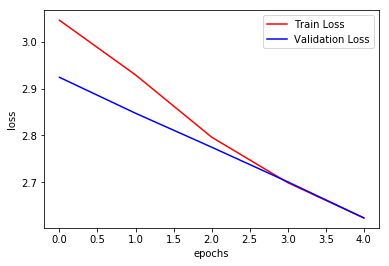

In [9]:
train_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
plt.plot(range(len(train_loss)), train_loss, color="red", label="Train Loss")
plt.plot(range(len(train_loss)), val_loss, color="blue", label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()